# 分类分析

有关回归分析的学习已基本完成，接下来我们将简单学习一波与回归分析相对应的内容——分类分析。

回归和分类是数据分析的两大重要任务，它们最大的区别在于因变量的类别：回归分析的因变量是连续变量；分类分析的因变量是分类属性变量。与回归分析一样，在进行分类分析之前，我们必须要弄清楚我们建模的目的是推断还是预测，任务的不同将很大程度决定我们建模所采用的方法论的不同——如果是以推断/分析为主，那么我们在建模时所采用的模型最好是易于解释的白盒模型，如一众线性模型；如果是以预测为主，则我们建模的依据主要是预测的精度，模型的可解释性相对而言不那么重要。

对于分类任务而言，当前预测精度高的模型基本上都是深度学习/机器学习模型（如：支持向量机、随机森林、Xgboost等），而这些模型的可解释性一般都很差，我们难以在这些模型中寻找变量之间的依存信息。而如果我们追求分类模型的可解释性，探究各自变量对分类决策的影响，那么使用线性模型框架下的分类模型就比较合适了（如：Logistic回归、Probit回归等）。

本次学习我们只学习可解释性强的线性分类模型，有关机器学习、深度学习模型的学习，将在后续的课程展开，敬请期待！

# 0. 分类问题与对应模型

在现实生活中，我们会遇到许多与分类有关的问题，分类问题按照被分类对象的类别划分，总共可以分为三类：二分类问题、无序多分类问题、有序多分类问题。

二分类问题是最简单也是最常见的分类问题，如我们要研究客户流失跟哪些因素有关，从而对客户流失做出预警，此时因变量就是客户“是”与“否”会流失；又例如根据短信正文的内容判断邮件是垃圾邮件还是正常邮件，这些都属于二分类问题。二分类问题可用二分类Logistic回归模型与Probit模型，这两个模型将是我们重点介绍的模型。

无序多分类问题是二分类问题的延伸，如我们要根据新闻内容对新闻主题进行分类，分类主题有体育、政治、娱乐、生活等。这种因变量类别多于两个，且类别间没有大小顺序的分类问题，被称为无序多分类问题，可用多类别logistic回归模型建模。

有序多分类问题也称为定序问题，在问卷调查中常常出现，如我们要求消费者对产品进行满意度评价，评价结果包括不满意、一般、满意三个选项，我们可以将之赋值为1/2/3。这三个取值是存在先后大小之分的，这是与无序多分类问题最大的不同。对于这类问题，我们可用有序Logistic回归模型。

总结如下：

1. 二分类问题——二分类Logistic回归、Probit回归
2. 无序多分类问题——多分类Logistic回归
3. 有序多分类问题——有序Logistic回归

由于笔者没有在statsmodels与sklearn中找到有序Logistic回归的api，因此我们主要学习前面两种分类问题。

# 1. 二分类问题

## 1.1 线性回归模型是如何处理分类问题的？

我们用一个具体的案例来引入讨论。

**· Example12.** ST是我国股市特有的一项保护投资者利于的决策，当上市公司因财务状况不佳导致投资者难以预测其前景时，交易所会标记该公司股票为ST，并进行一系列限制措施。我们想研究被ST的公司其背后的因素，并尝试通过利用公司的财务指标提前预测某上市公司在未来是否会被ST，是一件很有意义的举措。而在这项任务中，因变量就是公司是否会被ST，数学表示为：
$$
y= \begin{cases}1, & S T \\ 0, & \text { Otherwise }\end{cases}
$$
该例中自变量是一些财务指标，如ARA、ASSET等，它们具体的意义在此不做赘述。

在回归问题中，对于一个待预测样本$x$，模型输出值$\hat{y}$的性质就是因变量的性质，例如：如果某个问题中因变量是价格，那么模型输出的值也应当是价格。但是分类问题不一样，以这个例子为例，模型是不可能直接回答我们结果是0还是1的，那么分类问题中模型一般输出什么呢？

**概率**！准确来说是在给定$x$下，$y=1$的概率
$$
P(y=1 \mid x)
$$


**· 线性概率模型(LPM)**

与回归问题因变量天然确定的情况不一样，分类问题中概率的形式是需要我们人为确定的，即我们要确定如何将线性模型的直接输出值$\hat{y}$映射成概率值$\widehat{P(y=1\mid x)}$。

我们可以看到多元线性模型的样本回归线
$$
\hat{y}=\hat{\beta}_0+\hat{\beta}_1x_1+\cdots +\hat{\beta}_kx_k
$$
的输出值$\hat{y}$是一个连续变量，而概率也是一个连续的变量，那么我们能不能让这个输出值$\hat{y}=\widehat{P(y=1 \mid x)}$呢？即有
$$
\widehat{P(y=1\mid x)}=\hat{y}=\hat{\beta}_0+\hat{\beta}_1x_1+\cdots +\hat{\beta}_kx_k
$$

这种直接将线性模型的输出$y$当做条件概率$P(y=1 \mid x)$的模型被称为线性概率模型(LPM)。在线性概率模型中，系数$\beta$可以被解释为：在其他因素保持不变的前提下，$x$每增加一个单位，$y$取1的概率平均增加$\beta$个单位。

LPM模型有一个很大的缺点——$\hat{y}$可能不在区间(0,1)内，而概率只能在(0,1)区间内。（当然，还有其他的缺点，但大家只需要记住这个就可以了）



**· 概率的映射**

LPM模型的缺点非常明显，在一般情况下并不建议大家使用LPM。既然将$y$直接视为条件概率不妥当，那有什么解决办法呢？

答案是——我们可以将线性模型输出值$y$放在一个映射函数中，将之映射为一个概率。而映射函数的不同决定了模型的形式、解释、训练方法的不同。在这里，我们介绍两种映射函数——Logistic函数与Probit函数

若映射函数为Logistic函数
$$
G(y)=\frac{1}{1+e^{-y}}
$$
则整个预测模型被称为Logistic线性回归模型

若映射函数为Probit函数
$$
\Phi(y)=P(Y \leq y)=\int_{-\infty}^{y} \frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2} x^{2}\right) d x
$$
则整个预测模型被称为Probit线性回归模型。注意到，Probit函数实际上就是标准正态分布的累积函数。

这两个函数的形状如下：
<img src='./images/映射.png'>
可以看到，这两个函数都具有单调递增性质的可逆函数，且值域位于(0,1)之间，是理想的概率映射函数。

## 1.2 Logistic线性回归模型

**· 模型形式**

记$y=x^{\prime} \beta=\beta_{0}+\beta_{1} x_{1}+\cdots+\beta_{k} x_{k}$，则Logistic回归模型形式为
$$
P(y=1 \mid x)=p\left( x \right) =\frac{1}{1+e^{-y}}=\frac{1}{1+e^{-x^{'}\beta}}
$$
以上形式还可以恒等变换为以下形式，便于我们对模型进行解释
$$
\log \left(\frac{p(x)}{1-p(x)}\right)=\beta_{0}+\beta_{1} x_{1}+\cdots+\beta_{k} x_{k}
$$
这个模型形式告诉我们，Logistic回归模型与一般多元回归模型的一大区别在于，前者的因变量是一个有关概率$p\left( y=1|x \right) $的函数，而后者的因变量只是其本身。

**· 模型解释**

要想解释这个模型中每个变量系数的意义，首先要弄清楚$\log \left(\frac{p(x)}{1-p(x)}\right)$的含义。

如果把$y=1$看作“成功”，$y=0$看作失败，则$p(x) /[1-p(x)]$就是成功与失败的概率比，被称为胜率(odd)。因此对于系数$\beta_j$，我们的解释是：当其他自变量不变时，变量$x_i$提升一个单位，胜率odd会提升$\beta_j \%$。

In [1]:
# 加载基础包
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

In [2]:
# 读取数据
ST=pd.read_csv('data/ST.csv')
ST.head()

,ARA,ASSET,ATO,ROA,GROWTH,LEV,SHARE,ST
0,0.192310,19.856048,0.0052,0.087710,-0.950727,0.445880,26.89,0
1,0.220120,20.910863,0.0056,0.016820,-0.942656,0.398686,39.62,0
2,0.325292,19.352623,0.0166,0.042468,-0.937440,0.303348,26.46,0
3,0.025729,21.438928,0.0028,0.018152,-0.852995,0.758250,60.16,0
4,0.533591,21.613339,0.2552,0.004147,-0.816704,0.726875,54.24,1


In [3]:
st_logit=sm.formula.logit('ST~ARA+ASSET+ATO+ROA+GROWTH+LEV+SHARE',data=ST).fit()
print(st_logit.summary())

Optimization terminated successfully.
         Current function value: 0.183849
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     ST   No. Observations:                  684
Model:                          Logit   Df Residuals:                      676
Method:                           MLE   Df Model:                            7
Date:                Wed, 17 Aug 2022   Pseudo R-squ.:                  0.1084
Time:                        15:27:13   Log-Likelihood:                -125.75
converged:                       True   LL-Null:                       -141.04
Covariance Type:            nonrobust   LLR p-value:                 7.477e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.8692      4.636     -1.913      0.056     -17.955       0.217
ARA            4.8797      1.

## 1.3 Probit线性回归模型

**· 模型形式**

Probit回归模型形式为
$$
p(x)=\Phi\left(x^{\prime} \beta\right)
$$
其中，$\Phi$就是标准正态分布的累积函数

**· 模型解释**

Probit模型的系数解释不直观，但可以确定的是，当$\beta_j>0$时，$x_j$的增加会导致响应概率$p(x)$的增加。

In [4]:
st_probit=sm.formula.probit('ST~ARA+ASSET+ATO+ROA+GROWTH+LEV+SHARE',data=ST).fit()
print(st_probit.summary())

Optimization terminated successfully.
         Current function value: 0.183018
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                     ST   No. Observations:                  684
Model:                         Probit   Df Residuals:                      676
Method:                           MLE   Df Model:                            7
Date:                Wed, 17 Aug 2022   Pseudo R-squ.:                  0.1124
Time:                        15:27:13   Log-Likelihood:                -125.18
converged:                       True   LL-Null:                       -141.04
Covariance Type:            nonrobust   LLR p-value:                 4.612e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9545      2.210     -2.242      0.025      -9.286      -0.623
ARA            2.6467      0.

## 1.4 模型推断

Logistic回归与Probit回归在统计推断上是一致的。与OLS估计的多元线性回归不同的是，这两种分类回归模型采用的是极大似然估计法对模型参数进行估计，在极大似然估计的一般理论下，我们可以证明模型估计系数$\hat{\beta}$是$\beta$的一致估计。

基于极大似然估计的Logistic回归与Probit回归与基于OLS的多元线性回归在参数假设检验的思想上是相似的，只不过它们的检验统计量所服从的分布会有所不同。

**· 单参数显著性检验**

假设设置如下：
$$H_{0}: \beta_{j}=\beta_{j 0} \leftrightarrow H_{1}: \beta_{j} \neq \beta_{j 0}$$
则单参数检验统计量为
$$
\frac{\hat{\beta}_{j}-\beta_{j}}{s d\left(\hat{\beta}_{j}\right)} \Rightarrow N(0,1)
$$
该统计量渐进服从标准正态分布，可以看到，python中播报的也是z统计量的p值。

In [5]:
print('logistic回归报告')
print(st_logit.summary().tables[1])
print('--------------------------------------------------')
print('probit回归报告')
print(st_probit.summary().tables[1])

logistic回归报告
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.8692      4.636     -1.913      0.056     -17.955       0.217
ARA            4.8797      1.492      3.270      0.001       1.955       7.805
ASSET          0.2466      0.224      1.100      0.271      -0.193       0.686
ATO           -0.5074      0.657     -0.772      0.440      -1.796       0.781
ROA           -0.6366      6.224     -0.102      0.919     -12.835      11.562
GROWTH        -0.8333      0.567     -1.470      0.142      -1.945       0.278
LEV            2.3542      1.201      1.960      0.050      -0.001       4.709
SHARE         -0.0111      0.011     -0.997      0.319      -0.033       0.011
--------------------------------------------------
probit回归报告
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

**· 多参数联合显著性检验**

在Logit模型与Probit模型中，我们同样可以检验部分因素的统计显著性，且检验的思想依旧是比较有约束模型与无约束模型的“差异度”。与多元线性回归模型不一样的是，分类模型没有残差平方和RSS的概念，那么联合检验的检验统计量自然也不是原来的F统计量了。但是，在似然理论下，存在一个比残差平方和更广泛的概念——离差(Deviance)，定义为
$$
\,\,\mathrm{Deviance} =-2\cdot log\left( likelihood(model) \right) 
$$
它是-2倍的模型对数似然比，而模型的对数似然比在summary播报中正是指标Log-Likelihood。

当两个模型的离差足够大时
$$
D_{r}-D_{u r}>C
$$
我们便可以拒绝原假设，认为参数是联合显著的。

与其他假设检验一样，我们需要知道该检验所采用的检验统计量及其服从的分布，计算p值后再判断是否拒绝原假设。在这个检验中，似然比检验统计量定义为
$$
L R=2\left(l_{u r}-l_{r}\right)=D_{r}-D_{u r} \sim^{H_{0}} \chi_{q}^{2}
$$
它服从自由度为约束个数$q$的卡方分布，因此我们需要用卡方分布累积分布函数。

我们用python实现logit模型多参数显著性检验，原假设设为
$$
H_{0}: \beta_{1}=\beta_{2}=\cdots=\beta_{7}=0
$$

In [6]:
# 训练有约束模型
st_logit_r=sm.formula.logit('ST~1',data=ST).fit()

# 计算检验统计量
st_logit_ll=st_logit.llf
st_logit_r_ll=st_logit_r.llf
LR=2*(st_logit_ll-st_logit_r_ll)

# 计算p值
pvalue=stats.chi2.sf(LR,7)
print('联合检验的p值为：{}'.format(pvalue))

Optimization terminated successfully.
         Current function value: 0.206192
         Iterations 7
联合检验的p值为：7.477102949763221e-05


## 1.5 分类预测

### 1.5.1 模型预测的原理

模型训练完成后，我们就可以针对给定的数据进行预测了，在这里我们以Logit模型为例，简述模型预测的原理。

对于一组给定的解释变量取值$x_0$，我们将之代入模型中计算概率值$p(x)$
$$
\hat{p}\left(x_{0}\right)=\frac{e^{x_{0}^{\prime} \hat{\beta}}}{1+e^{x_{0}^{\prime} \hat{\beta}}}
$$
这一概率是在样本自变量$x=x_0$下，$y_0=1$的概率。

In [7]:
# 输出st_logit模型对ST数据集前五个样本的预测p(x)
logit_pred=st_logit.predict()
print(logit_pred[:5])

[0.17513856 0.2029176  0.20690489 0.16213708 0.67290575]



有了计算出来的概率，接下来就要根据概率判断样本应当被划分为1类还是0类。如何判断呢？我们可以规定一个阈值$\alpha$，当概率$p(x)>\alpha$时，样本被划分为1类，否则划分为0类。即
$$
\hat{y}_{0}= \begin{cases}1, & \hat{p}\left(x_{0}\right)>\alpha \\ 0, & \text { Otherwise }\end{cases}
$$
一般情况下，阈值$\alpha$默认为0.5。

In [8]:
# 我们构建一个判定函数，使其可以输出st_logit模型对ST数据集前五个样本在阈值为0.5时的预测判定
logit_res=list()
for i in np.arange(len(logit_pred)):
    if logit_pred[i]>0.5: #阈值
        logit_res.append(1)
    else:
        logit_res.append(0)

# 输出前五个样本的预测
print('前五个样本的预测结果：{}'.format(logit_res[:5]))

前五个样本的预测结果：[0, 0, 0, 0, 1]


### 1.5.2 预测结果呈现——混淆矩阵与多指标

使用模型完成预测后，我们想要直观地获知模型预测的效果——模型预测正确率是多少？有多少ST=1样本被正确预测了，又有多少ST=0的样本被正确预测了？仅仅依靠预测正确率，我们可以全面地评判模型的预测性能吗？是否还有其他分类指标可供我们参考？本小节我们将探讨这些问题。值得注意的是，本小节的内容适用于评判各种分类模型的预测效果，不仅仅适用于线性分类模型。

我们将先介绍混淆矩阵，再介绍各种分类指标，因为这些分类指标的计算都依赖于混淆矩阵中的常量。

**· 混淆矩阵**

使用模型完成预测后，我们想要直观地获知模型预测的效果——模型预测正确率是多少？有多少ST=1样本被正确预测了，又有多少ST=0的样本被正确预测了？关于这些问题，我们可以使用分类问题中常用的工具——**混淆矩阵**来解决。

对于二分类问题，混淆矩阵的形式如下图所示

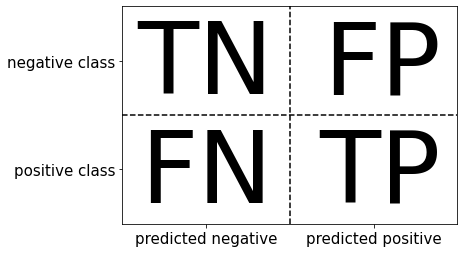

In [9]:
import mglearn
mglearn.plots.plot_binary_confusion_matrix()

在分类问题中，negative通常指代“反类”，分类标签通常设置为0；positive通常指代“正类”，分类标签通常设置为1。在二分类混淆矩阵中，横行表示样本实际的属性，纵列表示样本被模型预测的属性，如果两者不一致(FN/FP)就意味着预测错误，如果两者一致则意味着预测正确(TN/TP)。


<img src="./images/混淆矩阵.png">


在阈值0.5的前提下，logit模型的预测结果如下

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ST.ST,logit_res) # 注意：第一个值输入的是真实的标签集，第二个值输入的是预测的标签集

array([[647,   1],
       [ 35,   1]], dtype=int64)

**· 多分类指标——分类精度真的普适吗？**

我们紧接上面的混淆矩阵讨论有关分类指标的问题。

我们先计算一波在阈值$\alpha=0.5$下，logit模型的分类精度（也就是分类正确率），分类精度的公式为
$$
Accuracy=\frac{TP+TN}{TP+TN+FP+FN}
$$

In [11]:
# 计算logits模型分类精度
logit_accuracy=(647+1)/(647+1+35+1)
print('分类精度为{}'.format(logit_accuracy))

分类精度为0.9473684210526315


看上去分类精度接近95%，是一个非常不错的表现。但是我们稍加观察就会发现问题没有那么简单：在648个ST=0样本中，有647个样本被正确分类，只有1个样本被错误分类；但是在36个ST=1样本中，高达35个样本被错误分类，这说明logit模型在这个阈值下完全丧失了对1样本的预测能力。这是模型非常糟糕的表现，然而如果我们只关注到了约95%的高分类精度，我们会错误地认为模型表现得很好。

这种样本种类分布极其不均衡的现象被称为“样本不均衡”，对于这种样本的模型分类预测效果判断，仅靠分类精度是远远不够的，我们需要引入以下几个指标来解决这一问题——精确率、召回率、F分数。

**精确率(Precision)** 衡量的是所有被预测为正类的样本中，预测正确的比例，公式为：
$$
Precision=\frac{TP}{TP+FP}
$$

In [12]:
# 以st=1为正类，计算logits模型精确率
logit_precision=(1)/(1+1)
print('精确率为{}'.format(logit_precision))

精确率为0.5


**召回率(Recall)** 衡量的是所有正类样本中，预测正确的比例，公式为：
$$
\mathrm{Re}call=\frac{TP}{TP+FN}
$$

In [13]:
# 以st=1为正类，计算logits模型召回率
logit_recall=(1)/(1+35)
print('召回率为{}'.format(logit_recall))

召回率为0.027777777777777776


这两个指标侧重点各有不同。如果我们的分类目标是限制假正例（ST=0被预测为ST=1），那么精确率就可以很好的度量；如果我们想限制假反例（ST=1被预测为ST=0），那么召回率就可以很好的度量。具体采用何种指标评判模型，取决于我们分类的需求，我们举两个例子帮助大家理解。

**ex1.** 垃圾短信为正类1，正常短信为反类0

我们在进行垃圾短信分类时，将垃圾短信正确预测固然重要，但是我们更要防止将正常短信预测为垃圾短信（message=0被预测为message=1），因为遗漏正常短信的代价远远大于遗漏垃圾短信，此时，以垃圾短信为正类的精确率就是一个很好的度量指标。

**ex2.** 有癌症为正类1，无癌症为反类0

我们对病人进行癌症诊断时，一旦将实际上有癌症的病人预测为无癌症（cancer=1被预测为cancer=0），癌症病人将错失最佳治疗时机而产生危险，因此遗漏有癌症的代价远远大于遗漏无癌症，此时，以有癌症为正类的召回率就是一个很好的度量指标。

**F分数(F-score)** 是精确率与召回率的调和平均，是两者的综合取舍，公式为：
$$
F-score=2\cdot \frac{precision\cdot recall}{precision+recall}
$$

In [14]:
# 以st=1为正类，计算logits模型F分数
logit_f1=2*logit_recall*logit_precision/(logit_recall+logit_precision)
print('F分数为{}'.format(logit_f1))

F分数为0.05263157894736842


事实上，我们还可以使用一个输出以上所有指标的函数。

In [15]:
from sklearn.metrics import classification_report
print(classification_report(ST.ST,logit_res)) # 注意：第一个值输入的是真实的标签集，第二个值输入的是预测的标签集

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       648
           1       0.50      0.03      0.05        36

    accuracy                           0.95       684
   macro avg       0.72      0.51      0.51       684
weighted avg       0.93      0.95      0.92       684



这个函数会输出以0为正类、以1为正类的精确率、召回率、f分数（实际上这根据我们传入的标签集内的标签来定）。第一行就是以ST=0为正类的三种指标，第二行就是以ST=1为正类的三种指标，这也正是我们前面手动计算的三个指标。

### 1.5.3 对抗不平衡数据集——改变阈值

我们在前面看到了在阈值$\alpha=0.5$下，logit模型对ST=1的小样本的分类非常糟糕，这是为什么呢？

事实上，不平衡的数据集会导致模型的训练产生偏好性，由于ST=0的样本远远多于ST=1的样本，模型会更多地学习到ST=0的样本特征，而对ST=1的样本特征学习不足，于是对于一个未知样本，模型会更倾向于将它预测成大样本的类别。

在数学层面上，由于我们的概率$p$本质上是$P(y=1 \mid x)$，但是$y=0$样本却占了大多数，于是各样本预测出来的概率$p$将普遍偏小（小于0.5），我们可以观察一下。

In [16]:
# 观察前50个样本的预测p
print(logit_pred[:50]>0.5)

[False False False False  True False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


如何解决这一问题呢？既然样本的预测p普遍偏小，我们可以降低“门槛”$\alpha$，让其等于一个很小的数，这样子又可以有更多的样本被预测到ST=1的行列当中了。

In [17]:
logit_res=list()
for i in np.arange(len(logit_pred)):
    if logit_pred[i]>0.0526: #阈值
        logit_res.append(1)
    else:
        logit_res.append(0)

# 混淆矩阵
print(confusion_matrix(ST.ST,logit_res))

# 综合报告
print(classification_report(ST.ST,logit_res))

[[463 185]
 [ 11  25]]
              precision    recall  f1-score   support

           0       0.98      0.71      0.83       648
           1       0.12      0.69      0.20        36

    accuracy                           0.71       684
   macro avg       0.55      0.70      0.51       684
weighted avg       0.93      0.71      0.79       684



可以发现，在调整了阈值后，以ST=1为正类的召回率显著提升，更多的正类样本被正确划分了。

但与此同时，以ST=1为正类的精确率却下降了很多，假反例大大增加，这就是调整阈值所付出的代价。事实上，调整阈值是一把“双刃剑”，对于一个既定的模型，改变阈值并不会改变模型的预测性能，它只能改变样本预测的分布，使分布更符合我们实际的需求。如果需要改进预测效果，要么换一种精度更高的模型，要么进行调参处理，我们本节课不对这些内容进行讨论，感兴趣的同学可以关注我们后续有关机器学习的课程。

# 2. 无序多分类问题

介绍完了二分类Logistic回归，我们现在简单地学习一下无序多分类Logistic回归。有关二分类Logistic回归的研究起步早，理论与应用都相当成熟。相比之下，多分类Logistic回归的研究就相对滞后了，statsmodels包中似乎也找不到多分类Logistic回归的函数，因此本章节我们将使用机器学习包sklearn中的LogisticRegression函数。sklearn也具有做Logistic回归的功能，但它注重预测结果输出，而在统计推断结果的可视化上，sklearn做的远远不如statsmodels。因此本章节我们不介绍多分类Logistic回归的统计推断，只学习如何预测。

## 2.1 多分类Logistic回归的两种算法

K类别的多分类Logistic回归主要有两种：一种是修改概率映射函数，将其中一个类作为基类，通过修改过后的映射函数获得k-1个对数胜率；另一种是“一对其余”(one-vs-rest)，对每个类别都建立一个二分类Logistic回归，将本类别的样本定义为0，其余类别的样本定义为1，在所有类别的分类器中，概率$p$最高的类别就是实际判定的类别。

这么说可能有点抽象，我们接着往下看。

### 2.1.1 算法1：修改概率映射函数

**· 原理介绍**

我们回顾一下二分类Logistic回归的模型
$$
\log \left(\frac{p(x)}{1-p(x)}\right)=\beta_{0}+\beta_{1} x_{1}+\cdots+\beta_{k} x_{k}
$$
实际上我们可以将等式稍微变化一下
$$
\log \left( \frac{p(y=1|x)}{p(y=0|x)} \right) =\beta _0+\beta _1x_1+\cdots +\beta _kx_k
$$
它实际上比较的是1类和0类的概率。

而在多分类问题上，类别不仅仅有0和1，怎么比较其他类别的概率呢？我们可以选取一个类别作为基类（在这里我们选择0类），像上述公式一样分别计算0类与剩余类别之间的对数概率之比
$$
g_m\left( x \right) =\log \left( \frac{p(y=m|x)}{p(y=0|x)} \right) =\beta _{m0}+\beta _{m1}x_1+\cdots +\beta _{mk}x_k\text{，}m=1,…,M
$$
有M个类别，就会有M-1个函数，这些函数的实际意义是“目标类别$j$与基类$0$的对数胜率”。

计算出了M-1个函数$g_m\left( x \right)$后，我们便可以使用一个变式的Logit映射函数计算每个类别的条件概率$P(y=m\mid \mathbf{x})$
$$
P(y=m\mid \mathbf{x})=\frac{e^{g_m(\mathbf{x})}}{1+\sum_{m=1}^{M-1}{e^{g_m(\mathbf{x})}}}
$$

在进行模型预测的时候，我们可以先选出这M-1个概率中的最大概率者，在用这个概率与阈值$\alpha$进行比较。

**· 题外话**

这种算法是多分类Logistic回归的一种“标准的算法”，许多统计软件中的多分类Logistic回归所采用的算法就是这种算法，如spss、stata等等。笔者暂时没能在statsmodels包找到这种算法的api，因此本小节就不安排python实操了，如果大家学有余力，可以在statsmodels官方文档中自行探索，或者使用spss做这方面的统计分析。

### 2.1.2 算法2：一对其余算法

许多线性分类模型只适用于二分类问题，它们不能像Logistic回归一样有多分类的推广。于是，将二分类算法推广至多分类算法的一种常见方法就是“一对其余”。这种方法的思想非常简单，就是对每个类别都学习一个二分类模型，将这个类别与所有其余类别尽量分开，这样会生成与类别个数M相同个数的分类器，每个分类器都会输出一个概率，概率最高者“胜出”，并将这个类别的标签返回作为预测结果。

sklearn中的LogisticRegression的多分类形式就是采用了这样的算法。我们用一个含有三个类别、两个特征的玩具数据集来实操一波，来看看模型是如何处理多分类问题的。

In [18]:
# 加载基础包
import mglearn
import matplotlib.pyplot as plt
from IPython.display import display

In [19]:
# 加载数据集
from sklearn.datasets import make_blobs
X,y=make_blobs(random_state=42) 
print('前5个样本的X特征',X[:5])
print('前5个样本的y标签',y[:5])

前5个样本的X特征 [[-7.72642091 -8.39495682]
 [ 5.45339605  0.74230537]
 [-2.97867201  9.55684617]
 [ 6.04267315  0.57131862]
 [-6.52183983 -6.31932507]]
前5个样本的y标签 [2 1 0 1 2]


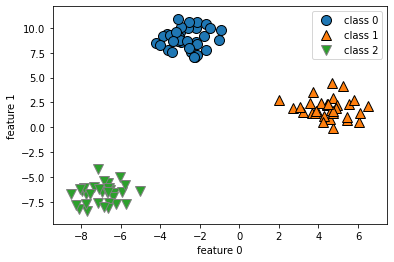

In [20]:
# 利用散点图对数据集进行可视化
mglearn.discrete_scatter(X[:,0],X[:,1],y)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend(['class 0','class 1','class 2'])


训练一个多分类Logistic回归模型，对上述样本进行分类。

In [21]:
from sklearn.linear_model import LogisticRegression
logis_multi=LogisticRegression(multi_class='multinomial').fit(X,y)
# 不同于statsmodels,在sklearn中我们需要在接口fit()中填入训练模型的数据，X为自变量数据，y为因变量数据

# 查看三个分类模型的模型参数
## 截距
print(logis_multi.intercept_)
## 系数
print(logis_multi.coef_)


[-1.63102014  1.85764971 -0.22662957]
[[-0.38486163  0.62874226]
 [ 0.74106233 -0.17664082]
 [-0.3562007  -0.45210144]]


根据输出，我们可以给出三个“一对其余”的模型公式，如第一个模型的公式就是
$$
\log \left( \frac{p\left( y=0|x \right)}{p\left( y\ne 0|x \right)} \right) =-1.63102014+-0.38486163x_1+0.62874226x_2
$$
我们将这三个分类器所代表的直线画到上图中

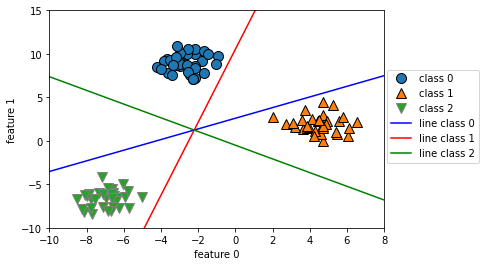

In [22]:
mglearn.discrete_scatter(X[:,0],X[:,1],y)
line_x=np.linspace(-15,15)
for coef,intercept,color in zip(logis_multi.coef_,logis_multi.intercept_,['b','r','g']):
    plt.plot(line_x,-(line_x*coef[0]+intercept)/coef[1],c=color)
plt.ylim(-10,15)
plt.xlim(-10,8)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend(['class 0','class 1','class 2','line class 0','line class 1','line class 2'],loc=(1.01,0.3))

我们可以看到，三条直线将样本空间分割成了不同的三角区域，那么哪些区域对应哪个类别呢？我们看看所有区域的预测结果：

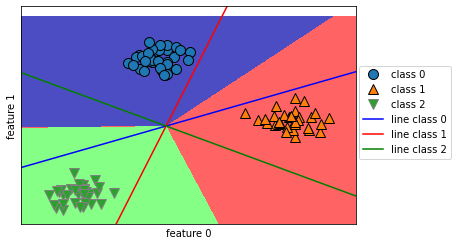

In [23]:
mglearn.plots.plot_2d_classification(logis_multi,X,fill=True,alpha=.7)
mglearn.discrete_scatter(X[:,0],X[:,1],y)
line_x=np.linspace(-15,15)
for coef,intercept,color in zip(logis_multi.coef_,logis_multi.intercept_,['b','r','g']):
    plt.plot(line_x,-(line_x*coef[0]+intercept)/coef[1],c=color)
plt.ylim(-10,15)
plt.xlim(-10,8)
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.legend(['class 0','class 1','class 2','line class 0','line class 1','line class 2'],loc=(1.01,0.3))

对应颜色的区域就是对应类别在三个分类器下划分的判定区域，可以看到，所有样本都被精准地分类。以上展示是为了让大家直观地看到二分类算法是如何使用“一对其余”思想进行多分类的。当然，由于本例中只有两个特征（两个自变量），所以我们可以用二维图像展示分类器所代表的直线与划分的区域，当特征维数大于2时，再用二维平面图展示就比较困难了。不过大家只需要记住，对于某一个具体样本的判别，只需看M个分类器所计算出的概率$p$最高者所代表的类别即可。

# 3. 以预测为目的分类问题实操流程——基于sklearn

## 3.1 划分训练集/测试集

在进行回归分析的学习之前，我们提到过，建模有两个主要的目的：推断与预测。

如果我们的目的是推断，则相对而言我们不太会注重考察模型的预测性能；如果我们的目的是预测，那么正确衡量模型的预测性能就显得十分重要了。或许有同学可以注意到，在此之前我们总是将数据集中的全部样本进行模型拟合，再将这些样本进行预测。这样的操作在回归分析中无可厚非，因为回归分析的主要目的是推断数据中可能存在的变量间的相互关系；但是与侧重推断的回归分析不同，在现实问题中人们更关注分类问题的预测部分，因此客观地衡量模型预测性能十分重要。

在这个背景下，如果将用于拟合模型的数据再进行预测，我们所得到的预测结果将会过于乐观，就好比如果我们在高考训练时，提前拿到了高考真题卷练手，那么我们实际高考的分数肯定会非常高，这显然是不合理的。因此，我们需要将用于训练模型的数据与用于预测的数据分开，对于训练好的模型来说，预测数据是完全未知的，这样才可以客观的评价模型的预测性能。

In [24]:
# 以上面的make_blobs数据集为例

# 加载函数
from sklearn.model_selection import train_test_split

# 数据集切分
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0) # test_size为测试集数据量占原始数据的比例

print('train_size',len(X_train)/len(X))
print('test_size',len(X_test)/len(X))

train_size 0.75
test_size 0.25


## 3.2 训练模型/模型预测

切分完数据集后，我们便可以进行模型训练了。以logistic回归为例

In [25]:
from sklearn.linear_model import LogisticRegression
# 使用训练集进行训练
logit_multi=LogisticRegression(multi_class='multinomial').fit(X_train,y_train)
# 使用测试集进行预测
y_pred=logis_multi.predict(X_test)
# 查看预测结果
print(y_pred)

[1 0 0 2 2 1 2 0 2 0 2 0 1 0 1 2 2 0 2 1 0 2 1 2 1]


## 3.3 预测结果分析

完成预测后，我们需要对模型的预测结果进行分析，常见的分析指标有：分类精度，精确率，召回率，f分数等；当然，我们可以输出混淆矩阵。

In [26]:
# 查看分类精度
print('测试集分类精度',logis_multi.score(X_test,y_test)) # 传入需要进行预测数据集自变量与真实标签集

# 混淆矩阵
display(confusion_matrix(y_test,y_pred))

# 综合指标
print(classification_report(y_test,y_pred))

测试集分类精度 1.0


array([[ 8,  0,  0],
       [ 0,  7,  0],
       [ 0,  0, 10]], dtype=int64)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        10

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



以上就是分类问题最基本的流程，当然对于一个具体的预测任务而言，这些操作肯定是远远不够的，但是任何预测任务都是基于以上三个基本步骤展开的，希望大家能熟练掌握。

至此，分类分析的课程已经完成了。本次课程，我们着重介绍了Logistic回归模型在分类问题上的推断与预测、学习了分类模型对样本进行预测的基本原理以及多种分类指标，使大家对分类问题有一个宏观的认知。这些只是分类分析的入门，接下来就是漫长的机器学习与深度学习之路，欲知后事如何，请听下回分解！

# 作业1——二分类：信贷风险评估

我们想知道银行贷款审批中是否存在种族歧视，这是一个非常典型的“推断”问题，于是可采用线性回归分类模型对该问题进行探究。本次习题使用数据loanapp.dta，所使用的变量解释如下：

因变量：
<br>
· approve：贷款是否被批准（0为不批准、1为批准）

自变量：
<br>
· white：种族哑变量（0为黑人，1为白人）
<br>
· obrat：债务占比

由于数据集含有缺失值，我们先去除含有缺失值的样本（非习题）

In [27]:
loan=pd.read_stata('./data/loanapp.dta')
# 选取要用的变量组成新的数据集
loan=loan[["approve","white","hrat","obrat","loanprc","unem","male","married","dep","sch","cosign","chist","pubrec","mortlat1","mortlat2","vr"]]
loan.dropna() #去除含缺失值样本

,approve,white,hrat,obrat,loanprc,unem,male,married,dep,sch,cosign,chist,pubrec,mortlat1,mortlat2,vr
1,0.0,1.0,22.540001,34.099998,0.800000,3.2,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,1.0,19.000000,26.000000,0.895105,3.9,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,24.000000,37.000000,0.600000,3.1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,25.100000,32.099998,0.895522,4.3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,1.0,21.000000,33.000000,0.804348,3.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,1.0,1.0,20.299999,29.299999,0.897727,4.3,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1985,1.0,1.0,8.000000,20.000000,0.111111,3.2,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1986,1.0,1.0,56.099998,60.500000,1.000000,3.2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1987,1.0,1.0,16.000000,17.000000,0.455814,3.2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


**使用python进行实操并回答以下问题**

（1）：先考虑一个线性概率模型
$$approve = \beta_0+\beta_1white+u$$
如果存在种族歧视，那么$\beta_1$的符号应如何？

如果存在种族歧视，那么的符号应该大于0。因为黑人对应的white=0，所以不容易从黑人角度分析。相反的，因为对于白人white=1，其对应的approve=1，样本中白人:黑人=1681:308，因此如果存在种族歧视，那么就需要保证大部分的白人都能成功申请，所以要保证$\beta_1>0$

In [28]:
loan['white'].value_counts()

1.0    1681
0.0     308
Name: white, dtype: int64

（2）：用OLS估计上述模型，解释参数估计的意义，其显著性如何？实际上大吗？

In [29]:
loanapp_lm = sm.formula.ols("approve~white", data=loan).fit()
print(loanapp_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     102.2
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.81e-23
Time:                        15:27:17   Log-Likelihood:                -555.54
No. Observations:                1989   AIC:                             1115.
Df Residuals:                    1987   BIC:                             1126.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7078      0.018     38.806      0.0

参数$\beta_1>0$的估计值为0.2006。

其t值大于0，我们的原假设应该是$\beta_1>0$ ，而备择假设却是小于0，那么此时的p值肯定是大于0.5的，因此我们不能拒绝原假设，可以认为存在种族歧视。但实际上，黑人的approve都为0.7078，是否通过申请还得看具体的阈值。

（3）：在上述模型中加入数据集中的其他所有自变量，此时white系数发生了什么变化？我们仍然可以认为存在黑人歧视现象吗？

In [50]:
formula = "approve~" + "+".join(loan.columns[1:])
loanapp_lm_all = sm.formula.ols(formula, data=loan).fit()
print(loanapp_lm_all.summary())

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     25.86
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           1.84e-66
Time:                        16:36:26   Log-Likelihood:                -429.26
No. Observations:                1971   AIC:                             890.5
Df Residuals:                    1955   BIC:                             979.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9367      0.053     17.763      0.0

系数$\beta_1$下降为0.1288，但是其t值仍然>0，与（2）相同，仍然可以认为存在种族歧视。

（4）：允许种族效应与债务占比(obrat)有交互效应，请问交互效应显著吗？请解读这种交互效应。

In [51]:
formular_ur = "approve~" + "+".join(loan.columns[1:]) + "+I(white*obrat)"
loanapp_lm_ur = sm.formula.ols(formular_ur, data=loan).fit()
print(loanapp_lm_ur.summary())

formular_r = "approve~" +"+".join(loan.columns[2:])
loanapp_lm_r = sm.formula.ols(formular_r, data=loan).fit()

from statsmodels.stats.anova import anova_lm
anova_lm(loanapp_lm_r, loanapp_lm_ur)

                            OLS Regression Results                            
Dep. Variable:                approve   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     25.17
Date:                Wed, 17 Aug 2022   Prob (F-statistic):           2.37e-68
Time:                        16:36:39   Log-Likelihood:                -422.99
No. Observations:                1971   AIC:                             880.0
Df Residuals:                    1954   BIC:                             974.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1806      0.087  

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,1956.0,182.282812,0.0,NaN,NaN,NaN
1,1954.0,177.262206,2.0,5.020606,27.671617,1.410622e-12


从t检验的结果来看，交互项的p值为0.000，因此拒绝原假设，即不能认为不同人种间的债务占比相同；而F检验的结果也是相当显著，拒绝原假设，也就是说不同人种的申请成功率存在明显差异。综合来看，不同人种申请成功率存在明显差异，可以认为有债务占比的影响。

（5）：使用logit模型与probit模型重新（4）中的模型，观察变量系数及其显著性的变化。

In [56]:
loanapp_logit = sm.formula.logit(formula, data=loan).fit()
print(loanapp_logit.summary())

Optimization terminated successfully.
         Current function value: 0.304666
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                approve   No. Observations:                 1971
Model:                          Logit   Df Residuals:                     1955
Method:                           MLE   Df Model:                           15
Date:                Wed, 17 Aug 2022   Pseudo R-squ.:                  0.1863
Time:                        16:49:55   Log-Likelihood:                -600.50
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 8.693e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8017      0.595      6.393      0.000       2.636       4.967
white          0.9378      0.

In [57]:
loanapp_probit = sm.formula.probit(formula, data=loan).fit()
print(loanapp_probit.summary())

Optimization terminated successfully.
         Current function value: 0.304551
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                approve   No. Observations:                 1971
Model:                         Probit   Df Residuals:                     1955
Method:                           MLE   Df Model:                           15
Date:                Wed, 17 Aug 2022   Pseudo R-squ.:                  0.1866
Time:                        16:49:58   Log-Likelihood:                -600.27
converged:                       True   LL-Null:                       -737.98
Covariance Type:            nonrobust   LLR p-value:                 7.014e-50
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0623      0.313      6.585      0.000       1.449       2.676
white          0.5203      0.

相比于（3）中的模型，系数增加幅度较大，但是显著性没有明显变化，都是接受原假设，认为人种对贷款申请成功率有影响。

# 作业2——多分类：鸢尾花分类问题

鸢尾花分类问题是经典的多分类问题，我们使用sklearn的logisticRegression求解该问题。

In [33]:
# 下载数据集
from sklearn.datasets import load_iris
iris_dataset=load_iris()

# 提取数据集中的自变量集与标签集
iris_data=iris_dataset['data'] # 自变量
iris_target=iris_dataset['target'] # 标签集

**使用python进行实操并回答以下问题**

（1）：将原数据集划分为训练集与测试集，两者样本比例为3:1。

In [58]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(iris_data, iris_target, test_size=0.25, random_state=42)
print(f"训练集大小：{len(x_train)}")
print(f"测试集大小：{len(x_test)}")

训练集大小：112
测试集大小：38


（2）：使用训练集数据训练logistic回归模型，并分别对训练集与测试集数据进行预测，并将预测的结果分别储存在两个自定义的变量中。

In [59]:
lr = LogisticRegression(multi_class="multinomial", max_iter=1000).fit(x_train, y_train)
y_pred_train = lr.predict(x_train)
y_pred_test = lr.predict(x_test)
print(y_train)
print(y_pred_train)
print(y_test)
print(y_pred_test)

[0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 2 2 1
 1 2 1 0 1 2 0 0 1 1 0 2 0 0 1 1 2 1 2 2 1 0 0 2 2 0 0 0 1 2 0 2 2 0 1 1 2
 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2 2 1 2 1 1 2 2 0 1 2 0 1
 2]
[0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1 2 0 1 2 0 2 2 1
 1 2 1 0 1 2 0 0 1 2 0 2 0 0 2 1 2 2 2 2 1 0 0 2 2 0 0 0 1 2 0 2 2 0 1 1 2
 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2 2 1 2 1 1 2 2 0 1 1 0 1
 2]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]
[1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0]


（3）：使用函数接口计算出：模型对训练集数据的分类正确率、模型对测试集数据的分类正确率，比较它们孰高孰低，并思考为什么会有这样的差异。

In [60]:
confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
print("训练集数据:", np.diagonal(confusion_matrix_train).sum() / np.sum(confusion_matrix_train))
confusion_matrix_test = confusion_matrix(y_test, y_pred_test)
print("测试集数据:", np.diagonal(confusion_matrix_test).sum() / np.sum(confusion_matrix_test))

训练集数据: 0.9642857142857143
测试集数据: 1.0


按照常理而言，模型对训练集的拟合程度应该更好，所以正常情况下应该是模型在训练集上的分类正确率要高于测试集。但是这里出现了相反的情况，这其实跟我们的数据分布分不开的，机器学习模型的表现很大程度上依赖于数据，这里其实我们测试集样本相对较少，所以就可能出现对测试集的分类正确率更高。


（4）：给出测试集数据的混淆矩阵以及精确率、召回率、f分数的综合报告。

In [61]:

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [62]:
# 完整代码
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris_dataset=load_iris()

iris_data=iris_dataset['data']  # 自变量
iris_target=iris_dataset['target']  # 标签集

x_train, x_test, y_train, y_test = train_test_split(iris_data, iris_target, test_size=0.25, random_state=0)
lr = LogisticRegression(multi_class="multinomial", max_iter=1000).fit(x_train, y_train)
y_test_pred = lr.predict(x_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.94      0.97        16
           2       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38

